# TP3 : Équations différentielles
## PHY-3500: Physique numérique (H2021) - 19 mars 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import timeit
from astropy.time import Time
import de421
from jplephem import Ephemeris
from mpl_toolkits import mplot3d
from datetime import datetime
from datetime import timedelta
import pandas as pd

On définit une variable pour le nombre de secondes dans une année terrestre complète (365.25 jours). Cette variable sera réutiliser tout au long de ce travail.

In [2]:
SECONDS_IN_A_YEAR = 31_557_600

### Mécaniques céleste - comètes

#### Question a)

L'équation différentielle qui régit le mouvement du système comète-soleil est donné par:
$$ m \dfrac{d^2\textbf{r}}{dt^2} = - \left (\dfrac{GMm}{r^2} \right ) \dfrac{\textbf{r}}{r} $$

Puisqu'on considère que le mouvement est confiné dans un plan, les deux dimensions nécessaires pour décrire le mouvement sont données par les équations suivantes:
$$ \dfrac{d^2x}{dt^2} = -GM \dfrac{x}{r^3} $$


$$ \dfrac{d^2 y}{dt^2} = -GM \dfrac{y}{r^3} $$

Pour simplifier la démarche analytique, il est préférable de réécrire ces deux équations différentielles du deuxième ordre en quatre équations différentielles du premier ordre en utilisant un changement de variable suivant:

$$ \dfrac{dx}{dt} = v_x   \hspace{2cm}  \dfrac{dv_x}{dt} = -GM \dfrac{x}{r^3} $$

$$ \dfrac{dy}{dt} = v_y   \hspace{2cm}   \dfrac{dv_y}{dt} = -GM \dfrac{y}{r^3} $$

#### Question b)

On veut écrire un programme pour résoudre les équations énoncées à la question a) à l'aide de la méthode de Runge-Kutta d'ordre 4 à pas constant $h$. On réalise d'abord une classe nommée *RK4_solver* qui prend en entrée une fonction quelconque et ses conditions initiales et performe la résolution du système d'équations. La résolution est faite pour un nombre $N$ de tranches entre la valeur initiale et finale de la variable indépendante, soit le temps dans le cas présent. Il est donc important de noter que la valeur du pas $h$ est calculé de la façon suivante :

$$ h = \frac{\text{temps final} - \text{temps initial}}{N}.$$

In [3]:
class RK4_solver:
    """
    Cette classe définit la méthode Runge-Kutta d'ordre 4 qui 
    peut être utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """

    
    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe RK4_solver.
        
        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()
        
        self.func = func
        self.initial_conditions = initial_conditions

        
    def solve(self, initial_value: float, final_value: float, N: int) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches utilisées. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        h = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            
            r += self.get_delta(r, h)
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
    
    
    def get_delta(self, r: np.ndarray, h: float) -> float:
        """
        Getter de la valeur de la mise à jour à effectuer sur les variables du système d'équation.
        
        Parameters
        ----------
        r: Les valeurs des différentes variables du système. (np.ndarray)
        h: La grandeur du pas à effectuer. (float) 

        Returns
        -------
        delta: La mise à jour à effectuer sur les différentes variables du système. (float)
        """
        k1 = h*self.func(r)
        k2 = h*self.func(r+0.5*k1)
        k3 = h*self.func(r+0.5*k2)
        k4 = h*self.func(r+k3)
        delta = (k1 + 2*k2 + 2*k3 + k4)/6 
        
        return delta
        

Maintenant, la fonction qui incorpore les quatres équations différentielles présentés à la question a) doit être écrite.

In [4]:
def gravitational_differential_equations(r):
    """
    Système de 4 équations différentielles du premier ordre régissant le mouvement d'un corps autour du Soleil.

    Parameters
    ----------
    r: Les valeurs des différentes variables du système. (np.ndarray)

    Returns
    -------
    Les valeurs des 4 dérivées utilisées dans le système d'équation. (np.ndarray) 
    """
    G = const.G
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)


On désire utiliser les fonctions définies précédemment pour tracer un graphique de la position d'une comète. Cette comète possède les conditions initiales suivantes : $x=4 \times 10^{9} \mathrm{~km}, y=0, v_{x}=0$ et $v_{y}=500 \mathrm{~m} / \mathrm{s}$. Le pas $h$ doit être choisi pour calculer avec précision au moins 2 orbites complètes de la comète. On s'attend à ce que les deux orbites se superposent sur le graphique. On initialise d'abord la comète avec les bonnes conditions initiales.

In [5]:
x0 = 4*10**12 # m
y0 = 0 # m
vx0 = 0 # m/s
vy0 = 500 # m/s
initial_conditions = [x0, y0, vx0, vy0]

orbit_comet = RK4_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)


On peut ensuite chosir un temps initial et final pour la comète. Par inspection, on trouve que pour un pas $h$ qui permet la superposition des deux orbites, soit un pas plus grand qu'environ 200 000 tranches, la comète exécute 2 orbites en 100 années terrestres. On choisit donc un temps final de 100 ans et on fait varier le nombre de tranches $N$, donc le pas $h$ pour observer son impact sur le temps de calcul. On trace le graphique de l'orbite pour chaque cas.

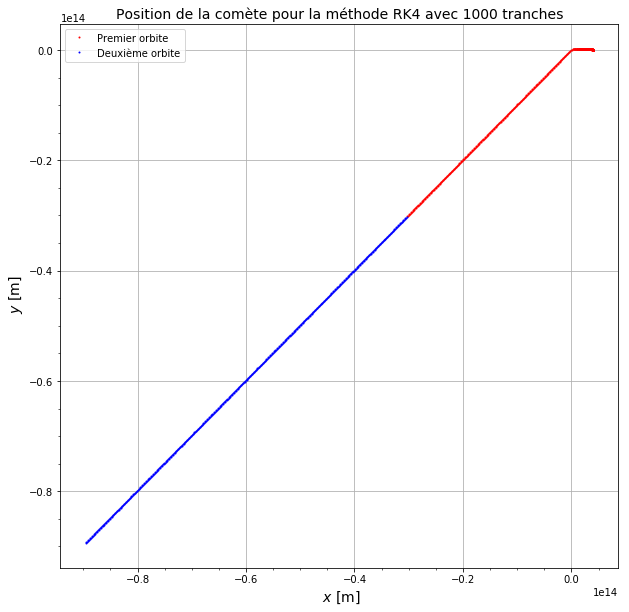

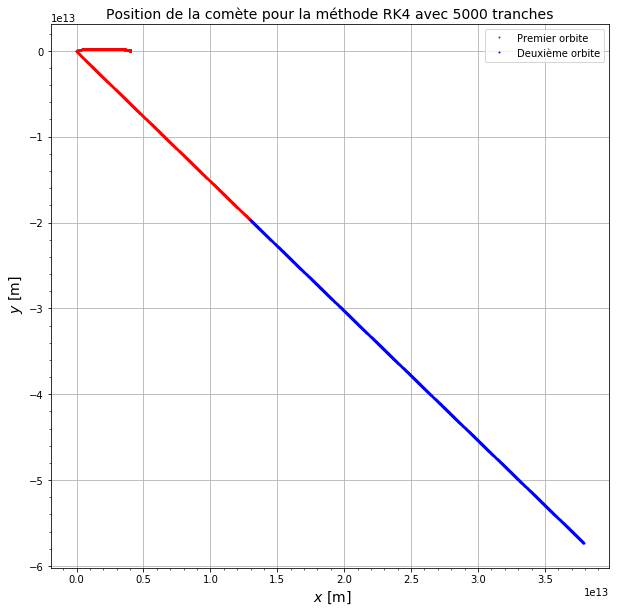

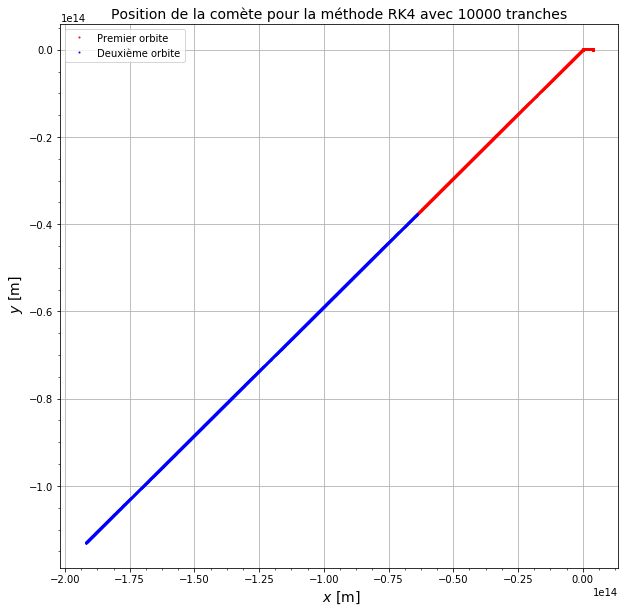

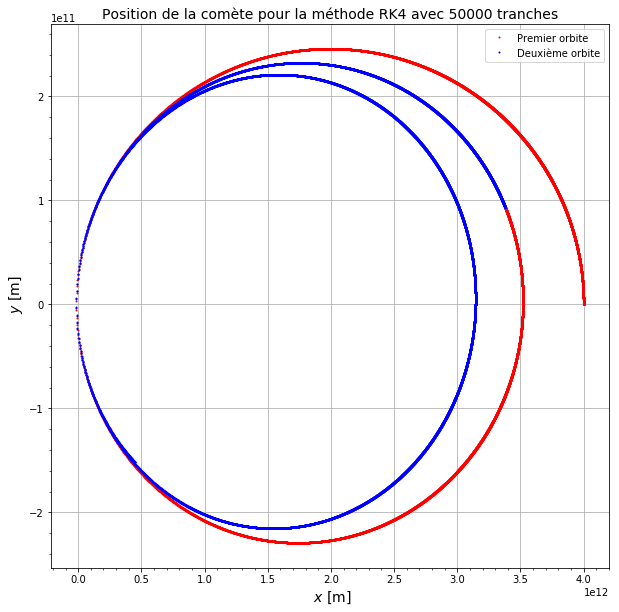

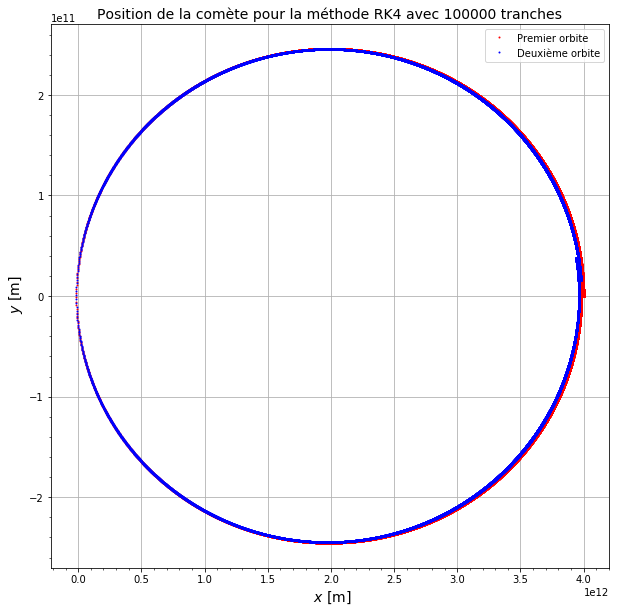

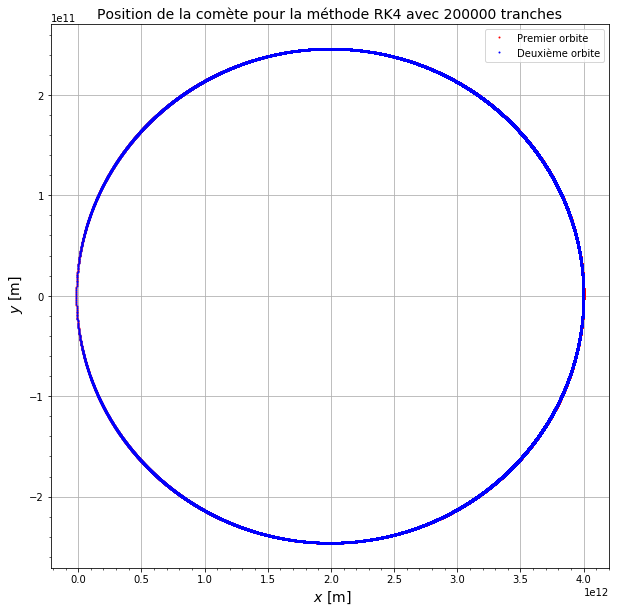

,Nombre de tranches [-],Temps de calcul de la méthode RK4 [s]
0,1000,0.04053660
1,5000,0.20242320
2,10000,0.42080850
3,50000,1.96150170
4,100000,3.82978130
5,200000,7.46773740


In [6]:
initial_time = 0 # s
final_time = SECONDS_IN_A_YEAR*100 # s
N = [1000, 5000, 10_000, 50_000, 100_000, 200_000]

nb_step_title = "Nombre de tranches [-]"
calculation_time_title = "Temps de calcul de la méthode RK4 [s]"

columns = [nb_step_title, calculation_time_title]
results = pd.DataFrame(columns=columns)
for n in N:
    starttime = timeit.default_timer()
    xpoints, ypoints = orbit_comet.solve(initial_value=initial_time, final_value=final_time, N=n)
    
    units = {
        nb_step_title: f"{n:.0f}",
        calculation_time_title: timeit.default_timer()-starttime,
    }
    
    results = results.append(units, ignore_index=True, )

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    line1, = ax.plot(np.split(xpoints, 2)[0], np.split(ypoints, 2)[0], marker='o', ls='None', color='r', markersize=1, 
                    label="Premier orbite")
    line2, = ax.plot(np.split(xpoints, 2)[1], np.split(ypoints, 2)[1], marker='o', ls='None', color='b', markersize=1,
                    label="Deuxième orbite")

    ax.set_title(f"Position de la comète pour la méthode RK4 avec {n} tranches", fontsize=14)
    ax.set_xlabel(" $x$ [m]", fontsize=14)
    ax.set_xlim()
    ax.set_ylabel(" $y$ [m]", fontsize=14)
    ax.minorticks_on()
    ax.legend()

    plt.grid()
    plt.show()
    plt.close(fig)


pd.options.display.float_format = "{:,.8f}".format
display(results)    


Par inspection visuelle, on remarque que les cas où le nombre de tranches est de 100 000 et de 200 000 sont ceux qui convergent vers la solution attendue, soit une orbite elliptique et une superposition des deux orbites de la comète. Plus le nombre de tranches $N$ est grand, plus le pas $h$ est petit. On comprend donc qu'avec un pas $h$ trop grand, l'algorithme de résolution des équations différentielles par Runge-Kutta diverge puisque les mises à jour des différentes variables de la fonction à évaluer n'approxime pas bien les changements réels rapides de la fonction. C'est pourquoi une méthode à pas adaptatif peut être ici plus intéressante, pour s'adapter aux fils des changements lents et rapides de la fonction à évaluer.

Au niveau des temps de calcul, on voit évidemment que plus le pas $h$ est petit, plus le calcul est long à exécuter puisque l'algorithme doit faire autant de mise à jour des variables qu'il y a de tranches $N$. Un tel problème consiste donc à trouver un compromis entre le temps de calcul et la précision désirée.


#### Question c)

On doit maintenant modifier la classe *RK4_solver* réalisé précédement pour rendre le pas adaptatif. Pour ce faire, on crée une nouvelle classe *RK4_adaptative_solver* qui hérite de la classe *RK4_solver* et on modifie la fonction *solve* pour rendre le pas adaptatif. 

In [7]:
class RK4_adaptative_solver(RK4_solver):
    """
    Cette classe définit la méthode Runge-Kutta d'ordre 4 
    à pas adaptatif qui peut être utilisée pour résoudre les 
    équations différentielles décrivant le mouvement d'un 
    corps en orbite autour d'un autre, soit le Soleil dans 
    le cas présent.
    """
    
    
    def solve(self, initial_value: float, final_value: float, delta: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        delta: Précision souhaitée par unité de la variable indépendante (le temps habituellement). (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        h = (final_value-initial_value)/10_000

        r = np.array(self.initial_conditions, float)
        
        tpoints = [initial_value, ]
        xpoints = [r[0], ]
        ypoints = [r[1], ]
        
        t = initial_value
        rho = 1
        while t < final_value:
            if rho < 2:
                h = h*(rho**(1/4))
            else:
                h = 2*h
            
            r1 = r + self.get_delta(r=r, h=h)
            r1 = r1 + self.get_delta(r=r1, h=h)
            
            r2 = r + self.get_delta(r=r, h=2*h)
            
            diff = r1 - r2
            rho = 30*h*delta/(np.sqrt(diff[0]**2 + diff[1]**2))
            
            if rho > 1:
                t = t + 2*h
                r = r1
                tpoints.append(t)
                xpoints.append(r[0])
                ypoints.append(r[1])
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints


 On initialise d'abord la comète avec les bonnes conditions initiales, qui sont les mêmes que celles de la question b). 

In [8]:
x0 = 4*10**12 # m
y0 = 0 # m
vx0 = 0 # m/s
vy0 = 500 # m/s
initial_conditions = [x0, y0, vx0, vy0]

orbit_comet_adaptative = RK4_adaptative_solver(func=gravitational_differential_equations, 
                                               initial_conditions=initial_conditions
                                              )


On choisit un temps final de 100 ans et une justesse de 1 km par année pour la position de la comète.

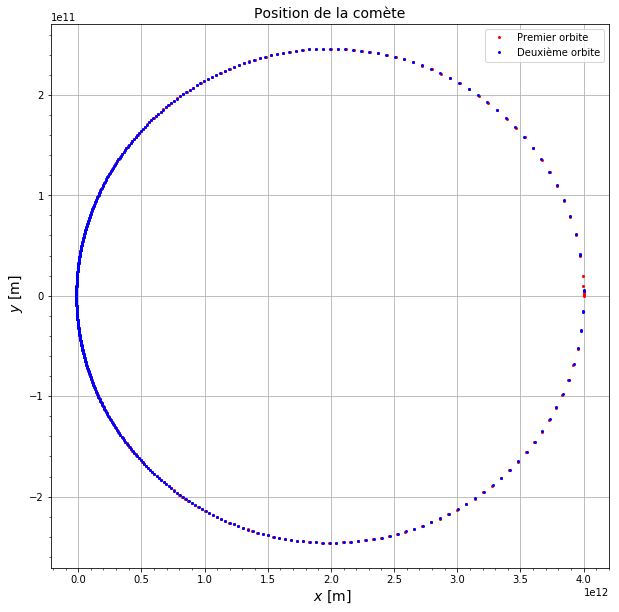

,Nombre de tranches [-],Temps de calcul de la méthode RK4 [s]
0,1000,0.04053660
1,5000,0.20242320
2,10000,0.42080850
3,50000,1.96150170
4,100000,3.82978130
5,200000,7.46773740
6,Pas adaptatif,0.19166990


In [9]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*100
delta = 1e3/(365*24*3600)

starttime = timeit.default_timer()   
xpoints, ypoints = orbit_comet_adaptative.solve(initial_value=initial_time, final_value=final_time, delta=delta)

units = {
    nb_step_title: "Pas adaptatif",
    calculation_time_title: timeit.default_timer()-starttime,
}

results = results.append(units, ignore_index=True, )


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(np.split(xpoints, 2)[0], np.split(ypoints, 2)[0], marker='o', ls='None', color='r', markersize=2,
                 label="Premier orbite"
                )

line2, = ax.plot(np.split(xpoints, 2)[1], np.split(ypoints, 2)[1], marker='o', ls='None', color='b', markersize=2,
                label="Deuxième orbite"
                )

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()
ax.legend()

plt.grid()
plt.show()
plt.close(fig)

display(results)


La méthode RK4 à pas adaptatif permet de réduire considérablement le temps de calcul par rapport à la méthode RK4 qui utilise un pas $h$ constant et d'obtenir la même forme pour l'orbite de la comète. La vitesse est en fait comparable à une exécution de l'algorithme avec un nombre de tranches autour de 5000, qui ne permettait pas de converger vers la solution. Par comparaison avec la vitesse d'éxecution de l'algorithme convergeant avec un nombre de tranches de 100 000, le temps de calcul de la méthode à pas adaptatif est environ 20 fois plus rapide.

Pour ce qui est de la densité de points sur la trajectoire, on remarque que la densité est minimale lorsque la comète est à son aphélie et que la densité est maximale à sa périhélie. Un tel comportement est attendue puisque la vitesse de la comète est plus grande à sa périhélie qu'à son aphélie. En d'autres mots, les équations du système varient plus vite lorsque la comète est à sa périhélie qu'à son aphélie et on s'attend à ce que le pas $h$ diminue afin d'approximer la trajectoire avec la justesse attendue. De même, le pas $h$ peut augmenter à son aphélie puisque la trajectoire plus lente devient plus facile à approximer. On sait que plus le pas $h$ est grand, moins la densité de points sera grande et le graphique montre bien cette dynamique.

Finalement, la justesse des calculs est directement donnée par la justesse désirée, soit une justesse de 1 km par année pour la position de la comète. Avec les méthodes à pas constant, la justesse était dépendante du nombre de pas $h$ et varie tout au long de la trajectoire de la comète. Toutefois, on comprend que la méthode à pas adaptatif est plus efficace que celle à pas constant puisqu'il suffit de spécifier une justesse et l'algorithme trouve le nombre de points optimales à calculer pour atteindre celle-ci.


### Mécanique céleste - la Terre

#### Question d)

On veut maintenant utiliser la méthode de Verlet pour calculer l'orbite de la Terre autour du Soleil. On réalise d'abord une classe nommée *Verlet_solver* qui prend en entrée une fonction quelconque et ses conditions initiales et performe la résolution du système d'équations. La résolution est faite pour un pas $h$ entre la valeur initiale et finale de la variable indépendante, soit le temps dans le cas présent.


In [10]:
class Verlet_solver:
    """
    Cette classe définit la méthode de Verlet qui peut être 
    utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """
    
    
    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe Verlet_Solver.

        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()

        self.func = func
        self.initial_conditions = initial_conditions
    
    
    def solve(self, initial_value: float, final_value: float, h: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        h: Pas utilisé. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        tpoints = np.arange(initial_value, final_value, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        f_mid = 0.5*h*self.func(r)

        vx_mid = r[2] + f_mid[2]
        vy_mid = r[3] + f_mid[3]

        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            r[0] += h*vx_mid
            r[1] += h*vy_mid

            k = h*self.func(r)
            r[2] += vx_mid + 0.5*k[2]
            r[3] += vy_mid + 0.5*k[3]
            f_mid = 0.5*h*self.func(r)
            vx_mid += k[2]
            vy_mid += k[3]
            
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
        

On désire utiliser les fonctions définies précédemment pour tracer un graphique de la position de la Terre. La Terre possède les conditions initiales suivantes : $x=1.4710 \times 10^{11} \mathrm{~m}, y=0, v_{x}=0$ et $v_{y}=3.0287 \times 10^{4} \mathrm{~m} / \mathrm{s}$.

In [11]:
x0 = 1.4710*10**11 # m
y0 = 0 # m
vx0 = 0 # m/s 
vy0 = 3.0287*10**4  # m/s

initial_conditions = [x0, y0, vx0, vy0]

orbit_earth = Verlet_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)


On peut ensuite chosir un temps initial et final pour la Terre. On décide de tracer deux orbites donc on choisit un temps initial de 0 seconde et un temps final de 2 ans. Les deux orbites sont tracées avec des couleurs différentes. Le pas $h$ est de 1 heure. 

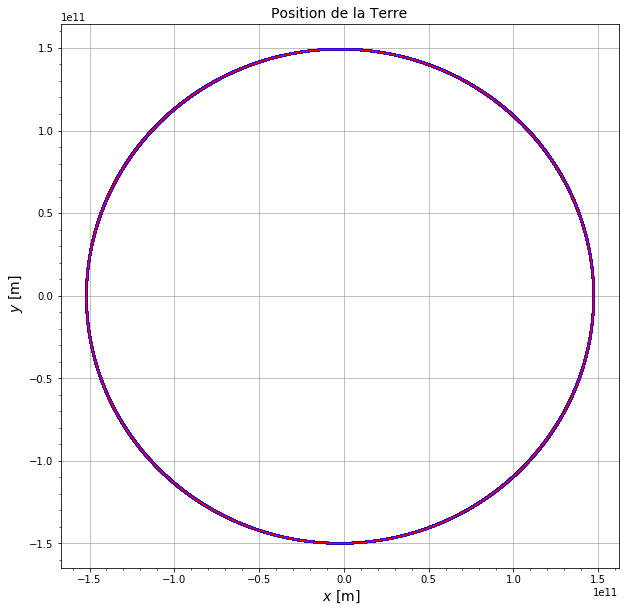

In [12]:
h = 3600   # Une heure


""" Premier orbitre de la comète """
initial_time = 0
final_time = SECONDS_IN_A_YEAR # 1 an
tpoints1 = np.arange(initial_time, final_time, h)

xpoints1, ypoints1 = orbit_earth.solve(initial_value=initial_time, final_value=final_time, h=h)


""" Deuxième orbitre de la comète """
initial_time = SECONDS_IN_A_YEAR # 1 an
final_time = SECONDS_IN_A_YEAR*2 # 2 ans
tpoints2 = np.arange(initial_time, final_time, h)

xpoints2, ypoints2 = orbit_earth.solve(initial_value=initial_time, final_value=final_time, h=h)


""" Figure de l'orbite"""
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(xpoints1, ypoints1, marker='o', ls='None', color='b', markersize=2)
orbit2, = ax.plot(xpoints2, ypoints2, marker='o', ls='None', color='r', markersize=0.2)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


Le graphique précédent montre bien l'orbite quasi circulaire de la Terre. On remarque aussi que les deux orbites se superposent presque parfaitement, ce qui montre que la méthode de Verlet performe bien.

#### Question e)

In [13]:
def get_energies(self, initial_value: float, final_value: float, h: float) -> tuple:
    """
    Getter des énergies cinétique, potentielle et totale.

    Parameters
    ----------
    initial_value: Valeur initiale de la variable indépendante. (float)
    final_value: Valeur finale de la variable indépendante. (float)
    h: Pas utilisé. (float)

    Returns
    -------
    tpoints, P, K, total_energy: Le temps, l'énergie potentielle, l'énergie cinétique et l'énergie totale. (tuple)
    """
    G = const.G
    M = const.M_sun
    m = const.M_earth

    tpoints = np.arange(initial_value, final_value, h)
    xpoints = []
    ypoints = []
    P = [] #Énergie potentielle 
    K = [] #Énergie cinétique

    r = np.array(self.initial_conditions, float)
    f_mid = 0.5*h*self.func(r)

    vx_mid = r[2] + f_mid[2]
    vy_mid = r[3] + f_mid[3]
    
    
    for t in tpoints:
        R = np.sqrt(r[0]**2 + r[1]**2)
        P.append(-G.value * M.value * m.value / R)
        K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
        r[0] += h * vx_mid
        r[1] += h * vy_mid
        k = h * self.func(r)
        r[2] = vx_mid + 0.5 * k[2]
        r[3] = vy_mid + 0.5 * k[3]
        f_mid = 0.5 * h * self.func(r)
        vx_mid += k[2]
        vy_mid += k[3]
    
    total_energy = np.array(K, float) + np.array(P, float)
    
    return tpoints, P, K, total_energy


In [14]:
Verlet_solver.get_energies = get_energies

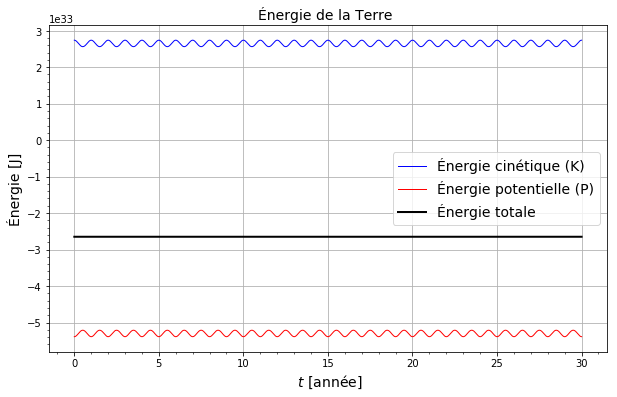

In [15]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*30 # 30 ans
h = 3600   # Une heure

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  #Vitesse en m/s

orbit_earth = Verlet_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

tpoints_verlet, P_verlet, K_verlet, total_energy_verlet = orbit_earth.get_energies(initial_value=initial_time, 
                                                                                   final_value=final_time, 
                                                                                   h=h
                                                                                  )

tpoints_verlet = tpoints_verlet/SECONDS_IN_A_YEAR

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints_verlet, K_verlet, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints_verlet, P_verlet, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


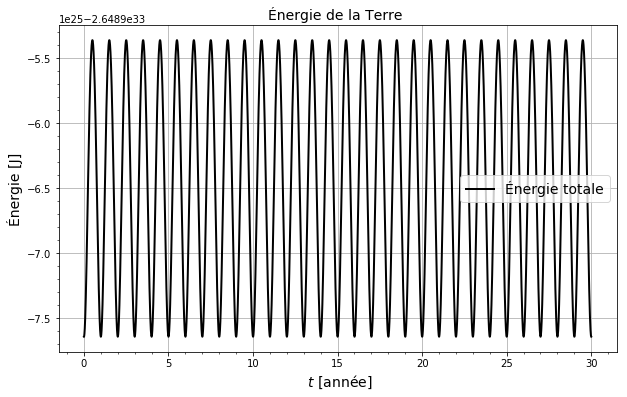

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observations:



#### Question f)

In [17]:
class RK2_solver(RK4_solver):
    """
    Cette classe définit la méthode de Runge-Kutta d'ordre 2 
    qui peut être utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """
    

    def get_energies(self, initial_value: float, final_value: float, N: int) -> tuple:
        """
        Getter des énergies cinétique, potentielle et totale.
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches utilisées. (float)

        Returns
        -------
        tpoints, P, K, total_energy: Le temps, l'énergie potentielle, l'énergie cinétique et l'énergie totale. (tuple)
        """
        G = const.G
        M = const.M_sun
        m = const.M_earth
    
        h = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, h)
        P = [] #Énergie potentielle 
        K = [] #Énergie cinétique
        
        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            R = np.sqrt(r[0]**2 + r[1]**2)
            P.append(-G.value * M.value * m.value / R)
            K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
            
            r += self.get_delta(r, h)
        
        total_energy = np.array(K, float) + np.array(P, float)
        
        return tpoints, P, K, total_energy
        
    
    def get_delta(self, r: np.ndarray, h: float) -> float:
        """
        Getter de la valeur de la mise à jour à effectuer sur les variables du système d'équation.
        
        Parameters
        ----------
        r: Les valeurs des différentes variables du système. (np.ndarray)
        h: La grandeur du pas à effectuer. (float) 

        Returns
        -------
        delta: La mise à jour à effectuer sur les différentes variables du système. (float)
        """
        k1 = h*self.func(r)
        k2 = h*self.func(r+0.5*k1)
        delta = k2
        
        return delta


In [18]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*2 # 2 ans
N = 100_000

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  # Vitesse en m/an

initial_conditions = [x0, y0, vx0, vy0]
orbit_earth = RK2_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)


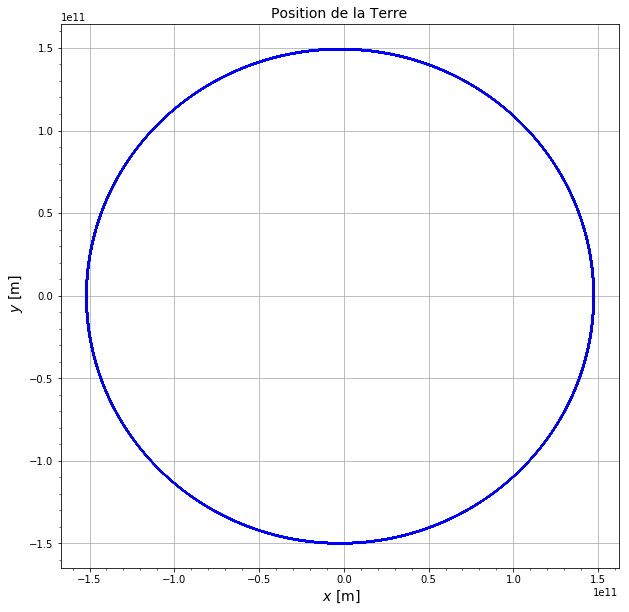

In [19]:
xpoints, ypoints = orbit_earth.solve(initial_value=initial_time, final_value=final_time, N=N)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=0.3)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


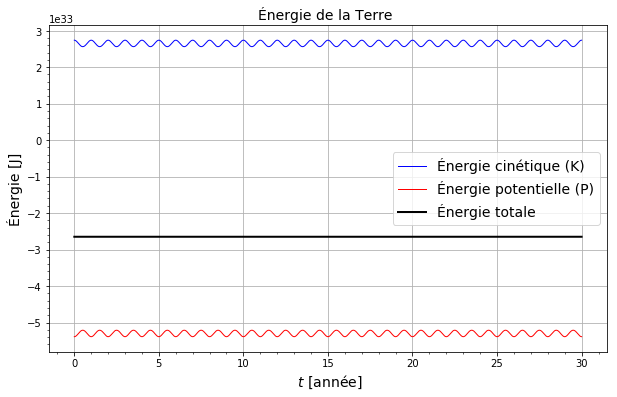

In [20]:
initial_time = 0
final_time = SECONDS_IN_A_YEAR*30
N = 100_000

tpoints_rk2, P_rk2, K_rk2, total_energy_rk2 = orbit_earth.get_energies(initial_value=initial_time, 
                                                                       final_value=final_time, 
                                                                       N=N
                                                                      )
tpoints_rk2 = tpoints_rk2/SECONDS_IN_A_YEAR

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints_rk2, K_rk2, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints_rk2, P_rk2, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints_rk2, total_energy_rk2, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


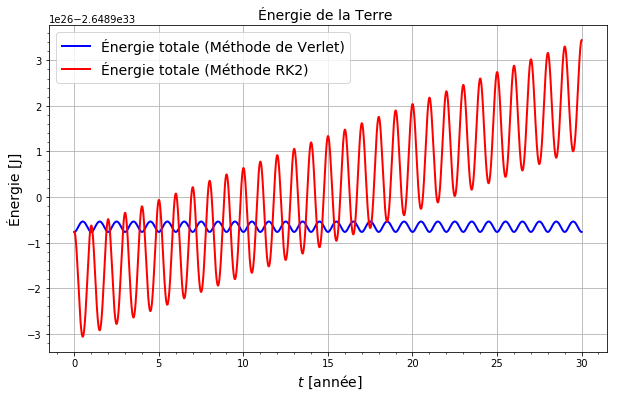

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum_verlet, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='b', linewidth='2', 
                            label="Énergie totale (Méthode de Verlet)"
                           )

energy_sum_rk2, = ax.plot(tpoints_rk2, total_energy_rk2, ls='-', color='r', linewidth='2', 
                          label="Énergie totale (Méthode RK2)"
                         )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum_verlet, energy_sum_rk2], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observation : https://femto-physique.fr/omp/methode-de-verlet.php#:~:text=Un%20des%20algorithmes%20symplectiques%20les,))%2Bh33!


#### Question g)
Dans cette section, une classe permettant de résourdre l'équation le système d'équation différentielles de l'attraction gravitationelle en 3D à l'aide de la méthode de Bulirsch-Stoer est réalisée à l'aide de l'implémentation de l'exemple 8.7 du Newman. 

In [22]:
class Bulirsch_Stoer_solver:
    

    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe Verlet_Solver.

        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()

        self.func = func
        self.initial_conditions = initial_conditions
    
    
    def solve(self, initial_value: float, final_value: float, N: float, delta: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches à utiliser "big steps". (int)
        delta: Précision voulue en unité de position/temps [m/s]. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        
        H = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, H)
        xpoints = []
        ypoints = []
        zpoints = []

        r = np.array(self.initial_conditions,float)

        for t in tpoints:
        
            xpoints.append(r[0])
            ypoints.append(r[1])
            zpoints.append(r[2])

            n = 1
            r1 = r + 0.5*H*self.func(r)
            r2 = r + H*self.func(r1)

            R1 = np.empty([1,6] ,float)
            R1[0] = 0.5*(r1 + r2 + 0.5*H*self.func(r2))

            error = 2*H*delta
            while error>H*delta:
                n += 1
                h = H/n
                # Modified midpoint method
                r1 = r + 0.5*h*self.func(r)
                r2 = r + h*self.func(r1)
                for i in range(n-1):
                    r1 += h*self.func(r2)
                    r2 += h*self.func (r1)
    
                R2 = R1
                R1 = np.empty([n,6] ,float)
                R1[0] = 0.5*(r1 + r2 + 0.5*h*self.func(r2))
                for m in range(1,n):
                    epsilon= (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
                    R1[m] = R1[m-1] + epsilon
                error= abs(epsilon[0])

            r = R1[n-1]
                
        xpoints, ypoints, zpoints = np.asarray(xpoints), np.asarray(ypoints), np.asarray(zpoints)
            
        return xpoints, ypoints, zpoints

In [23]:
def gravitational_differential_equations_3D(r):
    """
    Système de 4 équations différentielles du premier ordre régissant le mouvement d'un corps autour du Soleil.

    Parameters
    ----------
    r: Les valeurs des différentes variables du système. (np.ndarray)

    Returns
    -------
    Les valeurs des 4 dérivées utilisées dans le système d'équation. (np.ndarray) 
    """
    G = const.G
    M = const.M_sun
    
    x, y, z, vx, vy, vz = r
    R = np.sqrt(x**2 + y**2 + z**2)

    f_x = vx
    f_y = vy
    f_z = vz
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    f_vz = -G.value*M.value*z*R**-3
    
    return np.array([f_x, f_y, f_z, f_vx, f_vy, f_vz], float)

Dans cette section, la classe et la fonction réalisées aux sections précédentes sont utilisées afin de calculer l'orbite de la planète Terre sur un an avec une précision de 1 km/an par pas de 1 semaine.

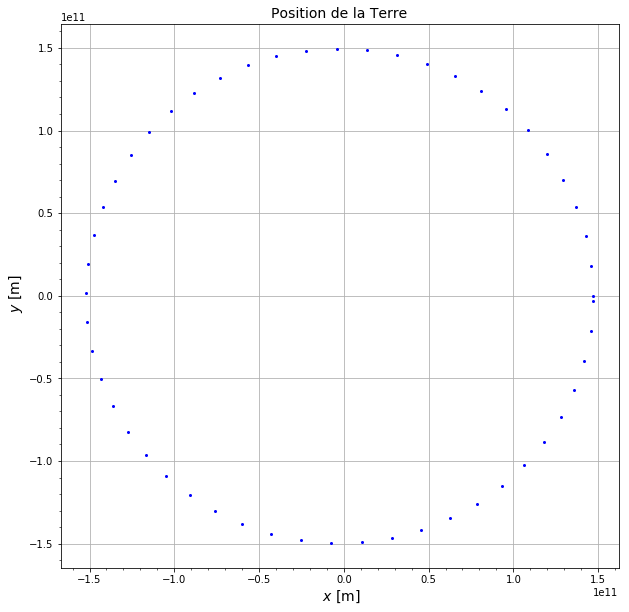

In [24]:
initial_value = 0
final_value = SECONDS_IN_A_YEAR # 1 an

x0 = 1.4710*10**11  # Position en m
y0 = 0
z0 = 0
vx0 = 0   
vy0 = 3.0287*10**4  # Vitesse en m/s
vz0 = 0

initial_conditions = [x0, y0, z0, vx0, vy0, vz0]
orbit = Bulirsch_Stoer_solver(func=gravitational_differential_equations_3D, initial_conditions=initial_conditions)

H = 6.048e5 # 1 semaine

N = (final_value-initial_value)/H # Nombre de tranches 

delta = 1000/SECONDS_IN_A_YEAR # précision voulue 1km/an

xpoints, ypoints, zpoints = orbit.solve(initial_value=initial_value, final_value=final_value, N=N, delta = delta)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=2)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

Tout d'abord, il est important de mentionner que la méthode de Bulirsch-Stoer est une méthode avec une précision fixe déterminée à l'avance et qui influence la résolution du système d'équations et que la méthode de Verlet est une méthode dont la précision est relative au pas de résolution. En effet, la précision de la méthode de Verlet est en $h^2$ tandis que la méthode de Bulirsch-Stoer est en $h^{2m}$. Dans le cas présent, la valeur maximale que prend m dans les calculs de l'orbite de la Terre pour la précision demandée est de 4,5 ou 6 et donc la précision est de l'ordre $h^{8}$, l'ordre $h^{10}$ ou l'ordre $h^{12}$ dépendamment des points ce qui est plus beaucoup plus précis que pour la méthode de Verlet. Or, tel qu'il est possible de constater en comparant le graphique de l'orbite terrestre présenté en d) et celui obtenu plus haut, les orbites obtenues sont très similaires. C'est entre autres un des avantages de la méthode de Bulirsch-Stoer qui permet de définir la précision voulue et que la méthode va s'adapter autour de cette précision autant que possible.

### Mécanique céleste - Mars

#### Question h)

Dans cette section, l'algorithme de calcul Bulirsch-Stoer est utilisé afin de calculer la position de la planète Mars le 18 février 2021 selon les coordonnées de la planète tirées des éphémérides de421 le 30 juillet 2020 ce qui aidera à calibrer le voyage de l'astromobile $\textit{Perseverance}$. Tout d'abord, les données sont extraites des éphémérides de421.

In [25]:
eph = Ephemeris(de421)

# dates
lancement=Time("2020-07-30")
atterissage=Time("2021-02-18")

# un nombre de jours juliens est attendu par la routine, d'où le .jd
# position en km, vitesse en km par jour
position1, velocity = eph.position_and_velocity('mars',lancement.jd)
positionend = eph.position('mars',atterissage.jd)

Ensuite, l'algorithme est utilisé afin de calculer le parcours qui sera utilisé pendant le voyage et comparé au résultats donnés par les éphémérides de421.

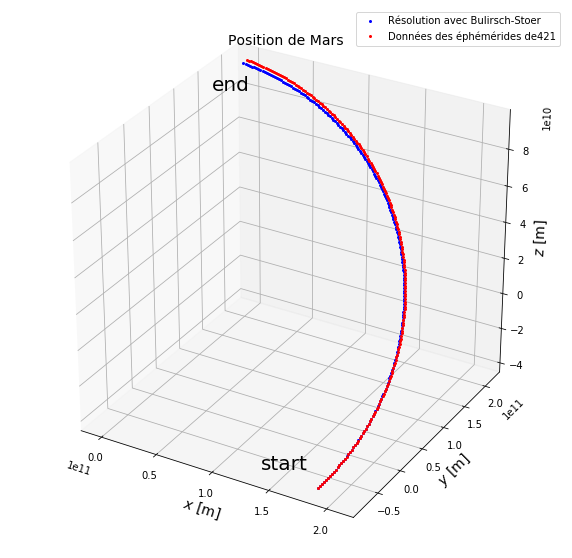

Position de Mars le 18 février 2021 selon la résolution de Bulirsch-Stoer = 
[-3448417623.6214776, 210720729392.35193, 96764759072.04935] m. 
 
Position de Mars le 18 février 2021 selon les éphémérides de421 = 
[-1945385232.669045, 214280416528.6719, 98309064272.3317] m. 
 
Cela donne, alors, une erreur de 77.26142697661432 % sur la position x, 
 de 1.661228400610128 % sur la position y et de de 1.5708675611074665% sur la position z. 
 
On obtient aussi que Mars, à ce moment, ce situe à une distance de 231901996494.25934 m  du Soleil 
selon la méthode de Bulirsch-Stoer et à une distance 235763766405.0735 selon les éphémérides de421 
ce qui donne une erreur de 1.6379827866251144 %. sur le rayon de l'orbite le 18 février 2021.


In [26]:
# Résolution du système d'équation avec Bulirsch-Stoer
initial_value = 0
final_value = 203*86400 # nombre de secondes du voyage

# Les éphémérides de421 donnent les distances en km.
x0 = float(position1[0])*1000  # Position en m
y0 = float(position1[1])*1000
z0 = float(position1[2])*1000

# Les éphémérides de421 donnent les vitesses en km/jour
vx0 = float(velocity[0])*1000/86400    
vy0 = float(velocity[1])*1000/86400    # Vitesse en m/s
vz0 = float(velocity[2])*1000/86400 

initial_conditions = [x0, y0, z0, vx0, vy0, vz0]
orbit = Bulirsch_Stoer_solver(func=gravitational_differential_equations_3D, initial_conditions=initial_conditions)

H = 86400 # 1 jour

N = (final_value-initial_value)/H # Nombre de tranches 

delta = 1/(SECONDS_IN_A_YEAR) # précision voulue 1m/an

xpoints, ypoints, zpoints = orbit.solve(initial_value=initial_value, final_value=final_value, N=N, delta = delta)

# Extraction des données de positions des éphémérides de421 pour les 203 jours du voyage.
my_string = '2020-07-30'

my_date = datetime.strptime(my_string, "%Y-%m-%d")

my_date_string = datetime.strftime(my_date, "%Y-%m-%d")

Date = Time(my_date_string)

position2 = eph.position('mars',Date.jd)

x_eph_list = []
y_eph_list = []
z_eph_list = []

x0 = float(position2[0])*1000  # Position en m
y0 = float(position2[1])*1000
z0 = float(position2[2])*1000

x_eph_list.append(x0)
y_eph_list.append(y0)
z_eph_list.append(z0)

for i in range(int(final_value/86400)):
    my_date += timedelta(days=1)
    my_date_string = datetime.strftime(my_date, "%Y-%m-%d")
    Date = Time(my_date_string)
    position2 = eph.position('mars',Date.jd)
    x = float(position2[0])*1000  # Position en m
    y = float(position2[1])*1000
    z = float(position2[2])*1000

    x_eph_list.append(x)
    y_eph_list.append(y)
    z_eph_list.append(z)
    
# Plot du graphique des positions de Mars selon la résolution et les éphémérides de421
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

Bulrisch_Stoer, = ax.plot(xpoints, ypoints, zpoints, marker='o', ls='None', color='b', markersize=2)
Ephemerides, = ax.plot(x_eph_list, y_eph_list, z_eph_list, marker='o', ls='None', color='r', markersize=2 )
ax.text(x0-0.5e11,y0,z0,  '%s' % 'start', size=20, zorder=1,  
 color='k') 
ax.text(xpoints[-1]-0.3e11,ypoints[-1],zpoints[-1]-0.2e11,  '%s' % 'end', size=20, zorder=1,  
 color='k')

ax.set_title("Position de Mars", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.set_zlabel(" $z$ [m]", fontsize=14)
ax.minorticks_on()

plt.legend(["Résolution avec Bulirsch-Stoer", "Données des éphémérides de421"])
plt.grid()
plt.show()
plt.close(fig)

# comparaison des positions obtenues avec celles des éphémérides
x1 = float(positionend[0])*1000  # Position en m
y1 = float(positionend[1])*1000
z1 = float(positionend[2])*1000

x_err = 100*abs((x1-xpoints[-1])/x1) # error %
y_err = 100*abs((y1-ypoints[-1])/y1) # error %
z_err = 100*abs((z1-zpoints[-1])/z1) # error %

radius_ephemeris = (x1**2+y1**2+z1**2)**0.5
radius_Bulirsch_Stoer = (xpoints[-1]**2+ypoints[-1]**2+zpoints[-1]**2)**0.5
r_err = 100*(radius_ephemeris-radius_Bulirsch_Stoer)/radius_ephemeris

print(f'Position de Mars le 18 février 2021 selon la résolution de Bulirsch-Stoer = \n' 
      f'{[xpoints[-1],ypoints[-1],zpoints[-1]]} m. \n \n'
      f'Position de Mars le 18 février 2021 selon les éphémérides de421 = \n' 
      f'{[x1,y1,z1]} m. \n \n'
      f'Cela donne, alors, une erreur de {x_err} % sur la position x, \n de {y_err} % sur la position y et de de {z_err}'
      '% sur la position z. \n \n' 
      f'On obtient aussi que Mars, à ce moment, ce situe à une distance de {radius_Bulirsch_Stoer} m  du Soleil \n'
      f'selon la méthode de Bulirsch-Stoer et à une distance {radius_ephemeris} selon les éphémérides de421 \n'
      f"ce qui donne une erreur de {r_err} %. sur le rayon de l'orbite le 18 février 2021.")


Selon les résultats obtenus, il est clair que la méthode utilisée possède ces limites. En effet, obtenir une erreur minimale d'un peu plus de 1.5% sur toutes les coordonnées n'est pas quelque chose de désirable surtout lorsqu'on parle de valeurs aussi grandes et que le but de ces calculs serait d'envoyer un astromobile sur mars. Considérant ces erreurs, si on envoyait l'astromobile selon aux coordonnées calculées, celui-ci n'arrivrait sûrement pas à destination. Ceci étant dit, les erreurs obtenues ne sont pas réellement causées par la méthode de résolution numérique utilisée puisque la précision utilisée pour résoudre le système d'équations est assez grande (1 m/an) et que la méthode de Bulirsch-Stoer est normalement une méthode très puissante de résolution d'équations différentielles ordinaires. C'est donc ici que l'on observe les limites de notre représentation assez simplistes du système solaire avec un système de 6 équations différentielles, soit 2 équations pour chacune des dimensions de l'espace. Dans notre cas, le système solaire est représenté par la méthode de perturbations générale qui ne prend en compte que les forces attractives du Soleil sur la planète choisie. Or, cette méthode n'est pas la meilleure approximation que l'on peut faire et n'est pas celle réalisée dans les calculs des éphémérides de421 [[1]](https://en.wikipedia.org/wiki/Jet_Propulsion_Laboratory_Development_Ephemeris). Les éphémérides de421 utilisent plutôt la méthode de perturbation spéciale qui repose le problème selon n-corps en considérant la masse de chacun plutôt que seulement la masse du Soleil et la position de Mars en plus d'incorporer des données basées sur les observations de la planète Mars. De plus, il est connu que le cycle de révolution d'une planète n'est pas quelque chose de parfaitement constant, il y a des petits changements à chaque année ce qui n'est pas pris en compte dans notre analyse. C'est alors plutôt un problème de modélisation que de résolution numérique.